In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from catboost import CatBoostClassifier, Pool

# Load Dataset

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
sample_sub_df = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

# Exploratory Data Analysis

In [4]:
train_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [5]:
print(f"Train Dataset Shape: {train_df.shape}")
print(f"Test Dataset Shape: {test_df.shape}")

Train Dataset Shape: (58645, 13)
Test Dataset Shape: (39098, 12)


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

We have 4 categorical features `person_home_ownership`, `loan_intent`, `loan_grade`,and `cb_person_default_on_file`. These needed to be represented to numbers.

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


In [8]:
common_columns = set(train_df.columns) & set(test_df.columns)
uncommon_columns = set(train_df.columns) ^ set(test_df.columns)  # XOR operation to get differences

print(f"Common Columns: {common_columns}\n")
print(f"Uncommon Columns: {uncommon_columns}\n")

Common Columns: {'person_age', 'id', 'loan_intent', 'person_income', 'loan_int_rate', 'person_emp_length', 'cb_person_default_on_file', 'loan_amnt', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership', 'loan_grade'}

Uncommon Columns: {'loan_status'}



`loan_status` is our target variable, we need to predict.

In [9]:
train_df.loan_status.value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

We can see some class imbalance here. 

## Data Distribution

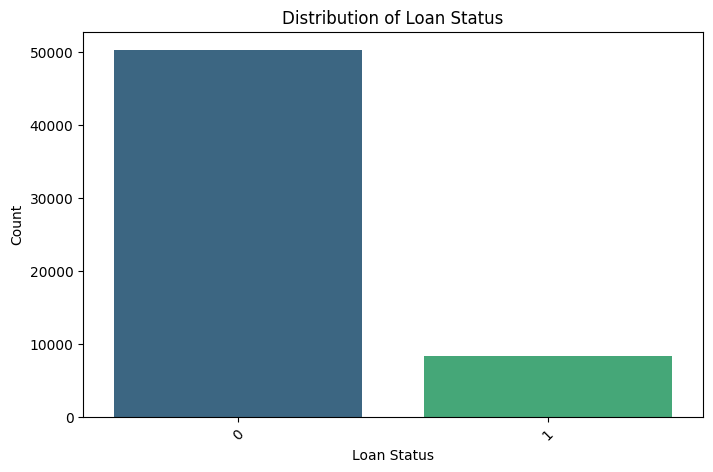

In [10]:
# Count the occurrences of each class in loan_status
loan_status_counts = train_df["loan_status"].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values, palette="viridis")

# Labels and title
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.title("Distribution of Loan Status")
plt.xticks(rotation=45)  # Rotate labels if needed
plt.show()

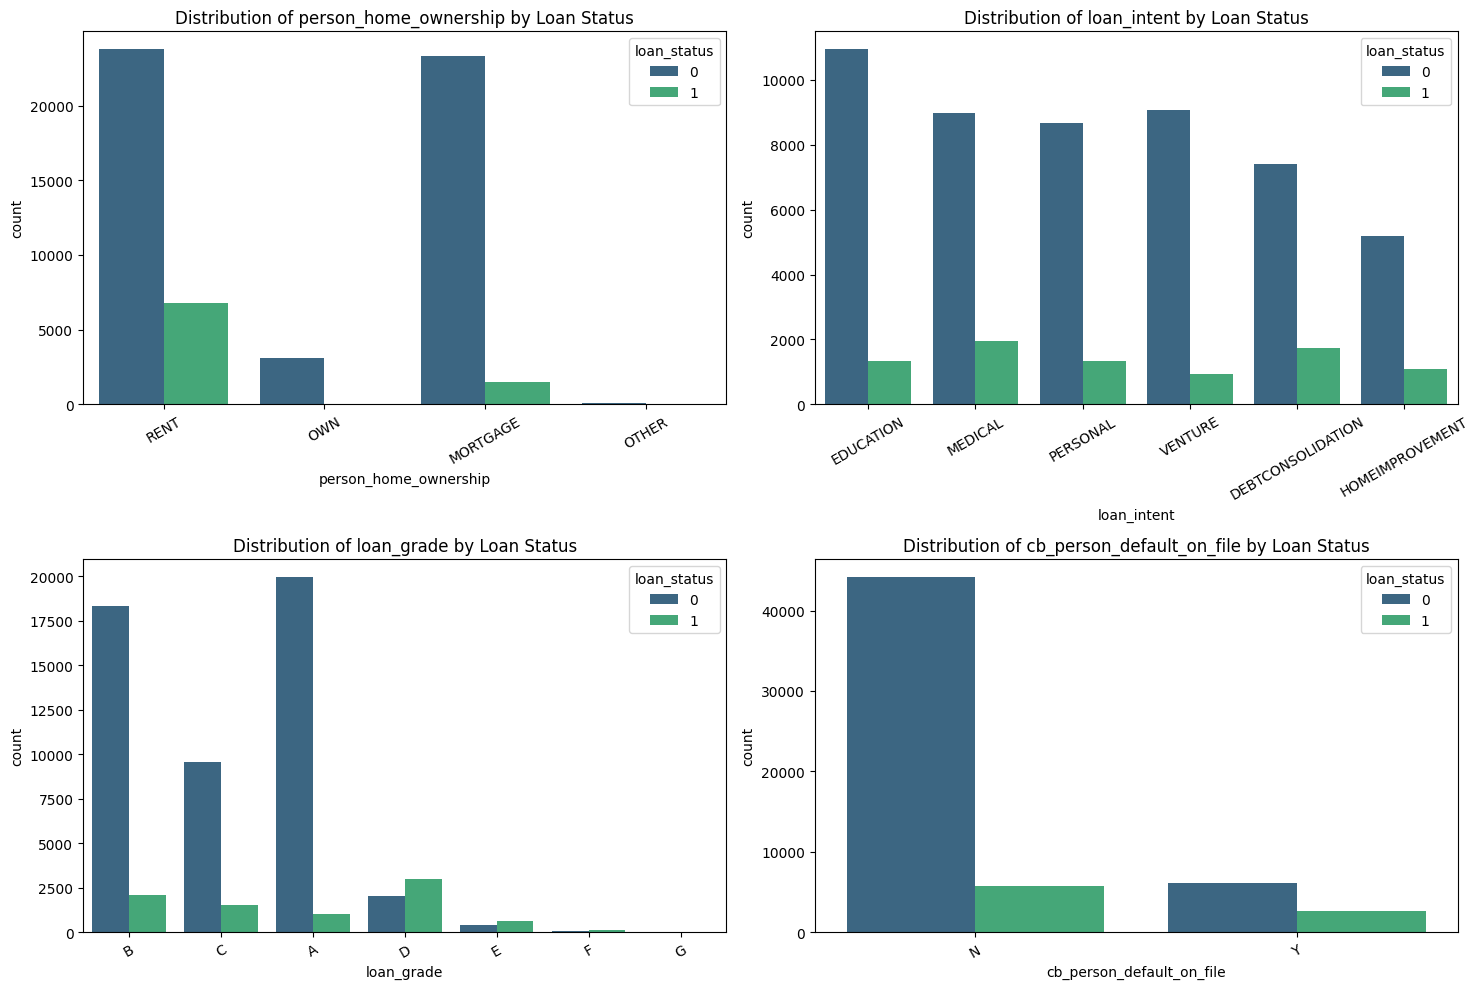

In [11]:
# Plotting the categorical data with respect to the loan_status, which is our target variable

categorical_features = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

plt.figure(figsize=(15, 10))

# Loop through each categorical variable and create a count plot
for i, col in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid for subplots
    sns.countplot(data=train_df, x=col, hue="loan_status", palette="viridis")
    plt.title(f"Distribution of {col} by Loan Status")
    plt.xticks(rotation=30)  # Rotate labels for better readability

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

There are `4` categorical features are identified, and they have low cardinality (i.e., a small number of unique values). The remaining features are numerical.

This dataset is very imbalanced. This means the model might be biased toward the majority class, so techniques like __resampling__, __adjusting class weights__, or __F1-score__ should be considered..

Here is what we can do
1. `Undersampling (Reduce Majority Class)`:
       - Randomly remove samples from the majority class to balance the dataset.
       - Works well for large datasets but risks losing important information.
2. `Oversampling (Increase Minority Class)`:
       - Duplicate or create synthetic samples of the minority class.
       - Helps retain all data but may lead to overfitting.
3. Adjusting class weights to give higher importance to the minority class.

4. Using algorithms/classifiers that can handle __class imabalanceness__, __performs good in larger dataset__.

## Checking Null Values

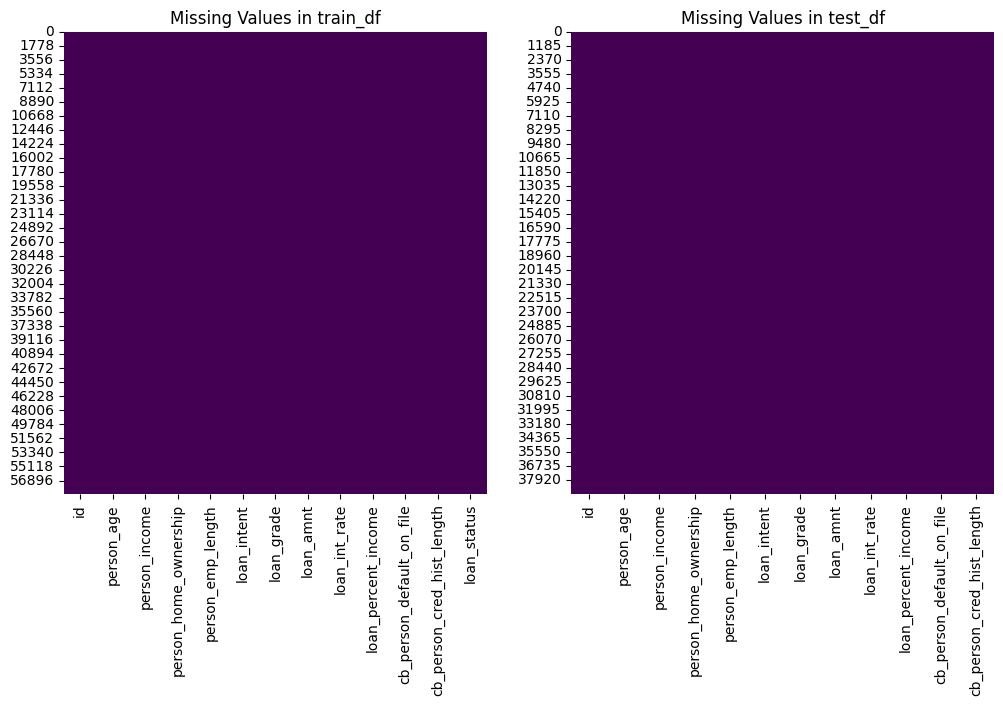

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in train_df")

plt.subplot(1, 2, 2)
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in test_df")

plt.show()

Our dataset doesn't contain any null values.

## Checking Duplicates

In [13]:
print(f"Number of duplicate values in Train dataset: {train_df.duplicated().sum()}")
print(f"Number of duplicate values in Test dataset: {test_df.duplicated().sum()}")

Number of duplicate values in Train dataset: 0
Number of duplicate values in Test dataset: 0


## Categorical Features

In [14]:
train_df['person_home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [15]:
train_df['loan_intent'].unique()

array(['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION',
       'HOMEIMPROVEMENT'], dtype=object)

In [16]:
train_df['loan_grade'].unique()

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

In [17]:
train_df['cb_person_default_on_file'].unique()

array(['N', 'Y'], dtype=object)

We need to convert these into number.

## Features contributing to the Target Variable.


In [18]:
df = train_df.copy()

In [19]:
# Define features (X) and target (y)
X = df.drop(columns=["loan_status"])  # Drop target variable
y = df["loan_status"]  # Target variable

In [20]:
# Identify categorical features
categorical_features = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

# Encode categorical features
encoder = OrdinalEncoder()
X[categorical_features] = encoder.fit_transform(X[categorical_features])

In [21]:
# Compute Mutual Information
mutual_info = mutual_info_classif(X, y, random_state=42)

# Convert to Pandas Series
mutual_info = pd.Series(mutual_info, index=X.columns)

# Sort values in descending order
mutual_info = mutual_info.sort_values(ascending=False)

# Display results
mutual_info_df = pd.DataFrame(mutual_info, columns=['Mutual Information'])
print(mutual_info_df)

                            Mutual Information
person_income                         0.099013
loan_percent_income                   0.081107
loan_grade                            0.081019
loan_int_rate                         0.079717
person_home_ownership                 0.037772
loan_amnt                             0.017547
cb_person_default_on_file             0.014998
loan_intent                           0.009338
person_emp_length                     0.008439
person_age                            0.004770
id                                    0.000000
cb_person_cred_hist_length            0.000000


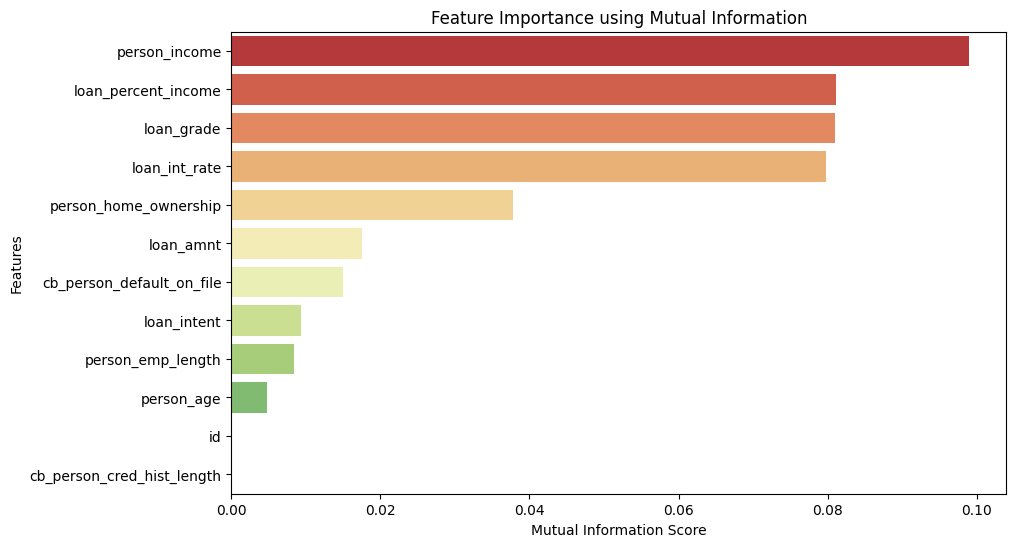

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x=mutual_info, y=mutual_info.index, palette="RdYlGn")
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.title("Feature Importance using Mutual Information")
plt.show()

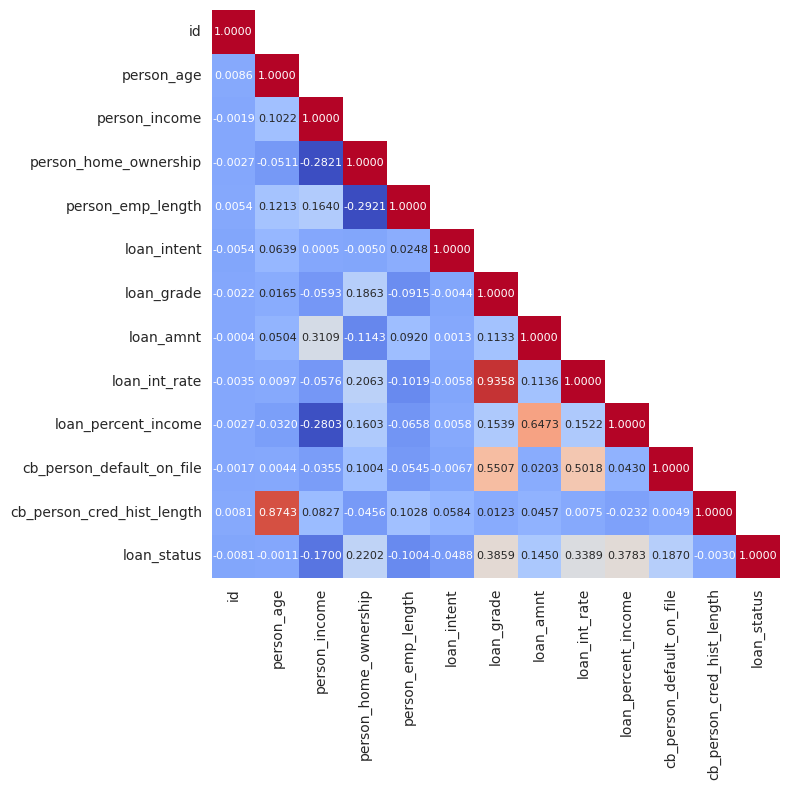

In [23]:
sns.set_style("white")
plt.figure(figsize=(8, 8))

corr_train = pd.concat([X, y], axis=1).corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.4f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    annot_kws={'size': 8},
    cbar=False
)

plt.tight_layout()
plt.show()

There is a good correlation between [`person_age` and `cb_person_cred_hist_lenght`] and [`loan_grade`, `loan_int_rate`], [`loan_amnt`, `loan_percent_income`].

# Data Processing

In [24]:
def prepare(train_df, test_df, categorical_features):
    """
    Applies Label Encoding to a categorical column in train and test DataFrames.

    Args:
        train_df (pd.DataFrame): Training dataset.
        test_df (pd.DataFrame): Testing dataset.
        column_name (str): The categorical column to encode.

    Returns:
        pd.DataFrame, pd.DataFrame: Updated train and test DataFrames.
    """
    for column in categorical_features:
        e = LabelEncoder()
        train_df[column] = e.fit_transform(train_df[column])
        test_df[column] = e.transform(test_df[column])  # Transform using the same encoder

    return train_df, test_df

In [25]:
categorical_features = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]
train_df, test_df = prepare(train_df, test_df, categorical_features)

This dataset is very clean, it has no null values, complex data etc. We can just jump straight to the model building and training.

# Model Building and Training

## Splitting Dataset into Features and Label for Training

In [26]:
features = train_df.drop(["loan_status"], axis=1)
label = train_df["loan_status"]

In [27]:
features.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14
1,1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2
2,2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10
3,3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5
4,4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3


In [28]:
label.head()

0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=40)

## Preparing Models

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [31]:
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [32]:
clfs = {
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [33]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    """
    Trains the classifier and evaluates it on the test set.

    Args:
        clf: The classifier instance.
        X_train: Training feature set.
        y_train: Training labels.
        X_test: Test feature set.
        y_test: Test labels.

    Returns:
        accuracy: Accuracy of the model on the test set.
        precision: Precision of the model on the test set.
        roc_auc: ROC AUC score of the model on the test set.
    """
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predict class labels for X_test
    y_pred = clf.predict(X_test)
    
    # Predict probabilities for X_test
    y_proba = clf.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    ruc_score = roc_auc_score(y_test, y_proba)

    return accuracy, precision, ruc_score

## Training

In [34]:
accuracy_scores = []
precision_scores = []
ruc_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision, current_ruc_auc_score = train_classifier(clf, X_train,y_train,X_test,y_test)

    print("================================================================================")
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print("RUC_AUC_SCORE - ", current_ruc_auc_score)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    ruc_scores.append(current_ruc_auc_score)

For  KN
Accuracy -  0.8786767840395601
Precision -  0.6105820105820106
RUC_AUC_SCORE -  0.7570207771382298
For  NB
Accuracy -  0.6257993008781653
Precision -  0.22490520854120935
RUC_AUC_SCORE -  0.6636053382678218
For  DT
Accuracy -  0.9417682666894024
Precision -  0.9422180801491147
RUC_AUC_SCORE -  0.907603689068972
For  LR
Accuracy -  0.8976042288345127
Precision -  0.7275607180570222
RUC_AUC_SCORE -  0.878965092524085
For  RF
Accuracy -  0.9508056952851905
Precision -  0.9313164349959117
RUC_AUC_SCORE -  0.9267021047797152
For  AdaBoost
Accuracy -  0.9259101372666041
Precision -  0.7987470634299139
RUC_AUC_SCORE -  0.9168530936193433
For  BgC
Accuracy -  0.9498678489214767
Precision -  0.9142857142857143
RUC_AUC_SCORE -  0.9267182168747463
For  ETC
Accuracy -  0.9475658623923608
Precision -  0.910411622276029
RUC_AUC_SCORE -  0.9165992446795495
For  GBDT
Accuracy -  0.9452638758632449
Precision -  0.9077429983525536
RUC_AUC_SCORE -  0.9266435125847904
For  xgb
Accuracy -  0.952425

## Saving Performance of the models

In [35]:
performance_df = pd.DataFrame({'ALGORITHM':clfs.keys(),'ACCURACY':accuracy_scores,'PRECISION':precision_scores, 'RUC_AUC_SCORE': ruc_scores}).sort_values('RUC_AUC_SCORE',ascending=False)
performance_df.head()

,ALGORITHM,ACCURACY,PRECISION,RUC_AUC_SCORE
9,xgb,0.952426,0.911179,0.950420
6,BgC,0.949868,0.914286,0.926718
4,RF,0.950806,0.931316,0.926702
8,GBDT,0.945264,0.907743,0.926644
5,AdaBoost,0.925910,0.798747,0.916853


In [36]:
performance_df1 = pd.melt(performance_df, id_vars = "ALGORITHM")
performance_df1

,ALGORITHM,variable,value
0,xgb,ACCURACY,0.952426
1,BgC,ACCURACY,0.949868
2,RF,ACCURACY,0.950806
3,GBDT,ACCURACY,0.945264
4,AdaBoost,ACCURACY,0.925910
5,ETC,ACCURACY,0.947566
6,DT,ACCURACY,0.941768
7,LR,ACCURACY,0.897604
8,KN,ACCURACY,0.878677
9,NB,ACCURACY,0.625799


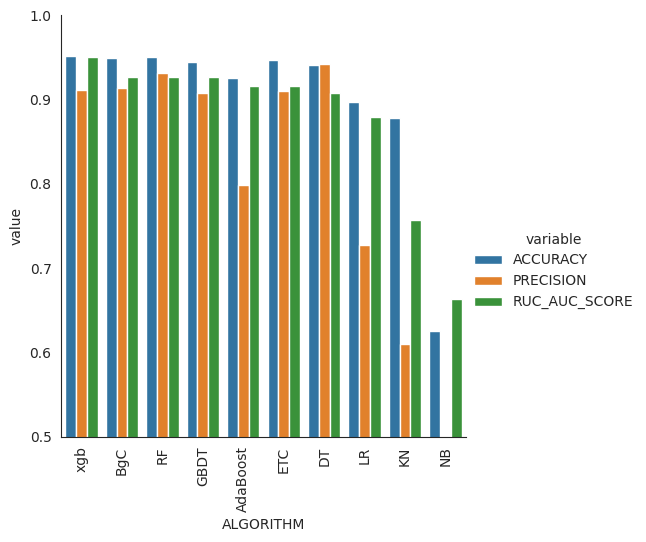

In [37]:
sns.catplot(x = 'ALGORITHM', y='value', hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

## Checking on Test Data

From the BarPlot we see,`xgb` is performing very well. Let's make prediction on this classifier.

In [38]:
y_pred = xgb.predict(test_df)
y_pred

array([1, 0, 0, ..., 0, 0, 1])

In [39]:
y_pred_proba = xgb.predict_proba(test_df)
y_pred_proba

array([[4.1657686e-04, 9.9958342e-01],
       [9.6753931e-01, 3.2460704e-02],
       [6.9068712e-01, 3.0931288e-01],
       ...,
       [9.9404556e-01, 5.9544183e-03],
       [6.4982224e-01, 3.5017776e-01],
       [2.9918611e-02, 9.7008139e-01]], dtype=float32)

# Submission

In [40]:
test = test_df['id']
# As I have predicted on xgb, result stored in y_pred
submission = pd.DataFrame({'id':test, 'loan_status':y_pred}) 
submission.to_csv('submission.csv' , index=False) 
submission

,id,loan_status
0,58645,1
1,58646,0
2,58647,0
3,58648,0
4,58649,0
...,...,...
39093,97738,0
39094,97739,0
39095,97740,0
39096,97741,0
